### Finding
* Pay attention to /players/p/pierza.01.shtml only player id with "."
* 681 unduplicated batters >= 162 PA between 2015 and 2019
* 1925 data points >= 162 PA between 2015 and 2019
* Some % data are string data type = >need to convert if be used

### Completed
* Web-scraping on baseball reference by year to get the list of 2015-2019 batters
* Web-scraping on baseball reference by players to get advance stats
* Data frame
* Data into sql database
* Merge Baseball Reference data with Baseball Savant data
* EDA

### To do
* Decide baseline features
* split the data
* baseline model

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [2]:
engine = create_engine('sqlite:///batters.db')

In [3]:
inspect(engine).get_table_names()

['br', 'players', 'statcast']

In [4]:
pd.read_sql('SELECT * FROM br;', engine).columns

Index(['index', 'Html_id', 'Name', 'Year', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'Pos_Summary', 'Awards', 'rOBA', 'Rbat+', 'BAbip', 'ISO', 'HR%', 'SO%',
       'BB%', 'EV', 'HardH%', 'LD%', 'GB%', 'FB%', 'GB/FB', 'Pull%', 'Cent%',
       'Oppo%', 'WPA', 'cWPA', 'RE24', 'RS%', 'SB%', 'XBT%', 'XBH%', 'X/H%',
       'SO/W', 'AB/SO', 'AB/HR', 'AB/RBI', 'GO/AO', 'IP%', 'HR/FB', 'IF/FB',
       'PA_cum', 'PA_cum_0', 'MLB_year', 'PA_0', 'PA_3y', 'PA_3y_0', 'PA_2y',
       'PA_2y_0', 'OPS+_3y', 'OPS+_3y_0', 'OPS+_2y', 'OPS+_2y_0', 'OPS+_last',
       'OPS+_next'],
      dtype='object')

In [5]:
pd.read_sql('SELECT * FROM statcast;', engine).columns

Index(['index', 'last_name', 'first_name', 'player_id', 'year', 'player_age',
       'b_total_pa', 'b_total_hits', 'b_home_run', 'b_total_pitches',
       'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrels', 'barrel_batted_rate', 'hard_hit_percent', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'out_zone_swing_miss', 'out_zone_swing',
       'out_zone_percent', 'meatball_swing_percent', 'meatball_percent',
       'iz_contact_percent', 'in_zone_percent', 'whiff_percent',
       'swing_percent', 'f_strike_percent', 'popups_percent', 'hp_to_1b',
       'sprint_speed', 'Unnamed: 33'],
      dtype='object')

In [6]:
########must run to update############
df = pd.read_sql('''SELECT b.name, s.first_name, s.last_name, b.year, b.mlb_year, b.age,
                           b.[ops+_last], b.[ops+_3y_0], b.[ops+_2y_0],
                           b.pa, b.pa_cum_0, b.pa_0, b.pa_2y_0, b.pa_3y_0, 
                           s.b_total_pitches * 1.0 / b.pa [p/pa], 
                           b.ev, b.[hardh%], s.launch_angle_avg, s.sweet_spot_percent, s.barrel_batted_rate,
                           b.[ld%], b.[gb%], b.[fb%], b.[gb/fb], 
                           b.[pull%], b.[cent%], b.[oppo%], 
                           b.[so/w], b.[go/ao], b.[ip%], b.[hr/fb], b.[if/fb],
                           s.z_swing_percent, s.z_swing_miss_percent, s.iz_contact_percent,
                           s.oz_swing_percent, s.oz_swing_miss_percent, s.oz_contact_percent,
                           s.meatball_swing_percent, s.whiff_percent, s.swing_percent,
                           s.popups_percent, s.sprint_speed, b.slg, b.babip, b.ops,b.[ops+]
                     FROM br b
                     JOIN statcast s
                     ON b.year = s.year
                     AND b.pa = s.b_total_pa
                     AND b.h = s.b_total_hits
                     AND b.hr = s.b_home_run;''', engine)#.dropna(how='any') 
#s.hp_to_1b, 
#Feature Engineering
df['Debut'] = pd.get_dummies(df.PA_3y_0, dummy_na=True).iloc[:, -1]
df['PA_0'] = df['PA_0'].fillna(0)
df['PA_2y_0'] = df['PA_2y_0'].fillna(0)
df['PA_3y_0'] = df['PA_3y_0'].fillna(0)
df['OPS+_last'].fillna(100, inplace=True)
df['OPS+_2y_0'].fillna(100, inplace=True)
df['OPS+_3y_0'].fillna(100, inplace=True)
df['Debut_Age'] = df['Age'] - df['MLB_year']
df['19_LA'] = df['launch_angle_avg'].map(lambda x : abs(x-19))
df['z_s_contact_percent'] = df['z_swing_percent'] * df['iz_contact_percent'] / 100
df['z_tot_miss_percent'] = 100 - df['z_swing_percent'] + df['z_swing_percent']*df['z_swing_miss_percent']/100
df['barrel_hard'] = df['HardH%'] - df['barrel_batted_rate'] 
df['barrel_sweet'] = df['sweet_spot_percent'] - df['barrel_batted_rate']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1925 non-null   object 
 1   first_name              1925 non-null   object 
 2   last_name               1925 non-null   object 
 3   Year                    1925 non-null   int64  
 4   MLB_year                1925 non-null   int64  
 5   Age                     1925 non-null   int64  
 6   OPS+_last               1925 non-null   float64
 7   OPS+_3y_0               1925 non-null   float64
 8   OPS+_2y_0               1925 non-null   float64
 9   PA                      1925 non-null   int64  
 10  PA_cum_0                1925 non-null   int64  
 11  PA_0                    1925 non-null   float64
 12  PA_2y_0                 1925 non-null   float64
 13  PA_3y_0                 1925 non-null   float64
 14  p/pa                    1925 non-null   

In [7]:
df.describe()

Year     MLB_year          Age    OPS+_last    OPS+_3y_0  \
count  1925.000000  1925.000000  1925.000000  1925.000000  1925.000000   
mean   2017.021818     5.182857    28.334026    98.634286    97.300693   
std       1.419914     3.870140     3.855108    36.883706    33.002469   
min    2015.000000     0.000000    19.000000  -100.000000  -100.000000   
25%    2016.000000     2.000000    25.000000    84.000000    83.333333   
50%    2017.000000     4.000000    28.000000   100.000000   100.000000   
75%    2018.000000     8.000000    31.000000   116.000000   112.666667   
max    2019.000000    21.000000    43.000000   559.000000   559.000000   

         OPS+_2y_0           PA      PA_cum_0         PA_0      PA_2y_0  ...  \
count  1925.000000  1925.000000   1925.000000  1925.000000  1925.000000  ...   
mean     97.887532   428.038961   2109.433766   370.684156   358.252468  ...   
std      33.695819   161.897648   2155.266875   222.436071   211.120128  ...   
min    -100.000000   162.000000      0.000000     0.000000     0.000000  ...   
25%      84.500000   280.000000    404.000000   187.000000   182.000000  ...   
50%     100.000000   428.000000   1422.000000   401.000000   386.000000  ...   
75%     113.500000   568.000000   3140.000000   566.000000   535.000000  ...   
max     559.000000   747.000000  11964.000000   745.000000   734.000000  ...   

             BAbip          OPS         OPS+        Debut    Debut_Age  \
count  1925.000000  1925.000000  1925.000000  1925.000000  1925.000000   
mean      0.299828     0.747045    99.023377     0.071169    23.151169   
std       0.037456     0.100044    25.361441     0.257173     1.893611   
min       0.145000     0.433000    11.000000     0.000000    19.000000   
25%       0.275000     0.681000    82.000000     0.000000    22.000000   
50%       0.300000     0.742000    98.000000     0.000000    23.000000   
75%       0.325000     0.809000   116.000000     0.000000    24.000000   
max       0.411000     1.109000   198.000000     1.000000    34.000000   

             19_LA  z_s_contact_percent  z_tot_miss_percent  barrel_hard  \
count  1925.000000          1925.000000         1925.000000  1925.000000   
mean      7.044935            55.348532           44.298931    32.572623   
std       4.092697             5.135395            5.154111     5.957532   
min       0.000000            39.028800           21.108000     8.700000   
25%       3.800000            51.685200           40.792600    29.000000   
50%       6.800000            55.257500           44.401600    33.000000   
75%       9.800000            58.911200           47.997500    36.500000   
max      20.500000            78.892000           60.971200    52.900000   

       barrel_sweet  
count   1925.000000  
mean      26.523169  
std        4.720128  
min        4.800000  
25%       23.300000  
50%       26.500000  
75%       29.800000  
max       42.200000  

[8 rows x 51 columns]

Baseline-> all training data  / cross-val(K1 K2 K3 K4 K5) / Test 20%

SELECT FEATURES/FEATURE ENIGERING  -> CROSS-VAL -> k2 MODEL -> TEST
5~10 FEATURES 


## Split data

In [8]:
#X, y = df.drop('OPS+',axis=1), df['OPS+']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)

## Baseline

In [9]:
select_columns = []

In [10]:
df_train.columns

Index(['Name', 'first_name', 'last_name', 'Year', 'MLB_year', 'Age',
       'OPS+_last', 'OPS+_3y_0', 'OPS+_2y_0', 'PA', 'PA_cum_0', 'PA_0',
       'PA_2y_0', 'PA_3y_0', 'p/pa', 'EV', 'HardH%', 'launch_angle_avg',
       'sweet_spot_percent', 'barrel_batted_rate', 'LD%', 'GB%', 'FB%',
       'GB/FB', 'Pull%', 'Cent%', 'Oppo%', 'SO/W', 'GO/AO', 'IP%', 'HR/FB',
       'IF/FB', 'z_swing_percent', 'z_swing_miss_percent',
       'iz_contact_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'meatball_swing_percent', 'whiff_percent',
       'swing_percent', 'popups_percent', 'sprint_speed', 'SLG', 'BAbip',
       'OPS', 'OPS+', 'Debut', 'Debut_Age', '19_LA', 'z_s_contact_percent',
       'z_tot_miss_percent', 'barrel_hard', 'barrel_sweet'],
      dtype='object')

In [11]:
X_train = df_train[['Age', 'Debut','OPS+_3y_0','PA_3y_0','PA_cum_0','p/pa','HardH%','launch_angle_avg',
                   'LD%','GB/FB','Pull%','Oppo%','z_swing_percent', 'iz_contact_percent', 
                    'oz_swing_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     74.97
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          7.93e-179
Time:                        19:03:26   Log-Likelihood:                -6715.4
No. Observations:                1540   AIC:                         1.346e+04
Df Residuals:                    1523   BIC:                         1.356e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -213.2455     31.212     -6.832      0.000    -274.469    -152.022
Age                   -0.9678      0.232     -4.175      0.000      -1.423      -0.513
Debut                  5.1554      2.311      2.231      0.026       0.623       9.688
OPS+_3y_0              0.0571      0.016      3.522      0.000       0.025       0.089
PA_3y_0                0.0152      0.004      3.726      0.000       0.007       0.023
PA_cum_0               0.0005      0.000      1.119      0.263      -0.000       0.001
p/pa                  10.8855      3.388      3.213      0.001       4.241      17.530
HardH%                 1.5415      0.069     22.254      0.000       1.406       1.677
launch_angle_avg      -0.2104      0.228     -0.923      0.356      -0.657       0.237
LD%                    1.4950      0.140     10.644      0.000       1.220       1.771
GB/FB                 -3.8673      1.185     -3.263      0.001      -6.192      -1.542
Pull%                  0.3385      0.120      2.827      0.005       0.104       0.573
Oppo%                  0.0299      0.174      0.172      0.863      -0.311       0.371
z_swing_percent        0.5681      0.122      4.671      0.000       0.330       0.807
iz_contact_percent     1.2015      0.125      9.580      0.000       0.955       1.448
oz_swing_percent      -0.3143      0.114     -2.756      0.006      -0.538      -0.091
sprint_speed           2.1410      0.384      5.573      0.000       1.387       2.895
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.046
Skew:                          -0.009   Prob(JB):                        0.977
Kurtosis:                       2.979   Cond. No.                     2.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## VIF

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [14]:
vif(df[['Age', 'Debut','OPS+_3y_0','PA_3y_0','PA_cum_0','p/pa','HardH%','launch_angle_avg','LD%',
        'GB/FB','Pull%','Oppo%','z_swing_percent', 'iz_contact_percent', 'oz_swing_percent','sprint_speed']])

Age                   159.652396
Debut                   1.628088
OPS+_3y_0              12.847919
PA_3y_0                11.778089
PA_cum_0                8.728349
p/pa                  365.086823
HardH%                 30.706819
launch_angle_avg       36.875909
LD%                    56.734491
GB/FB                  29.806941
Pull%                  53.619573
Oppo%                  47.086214
z_swing_percent       190.943454
iz_contact_percent    232.338442
oz_swing_percent       41.917665
sprint_speed          349.812874
dtype: float64

## Diagnostic_Plots

In [30]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

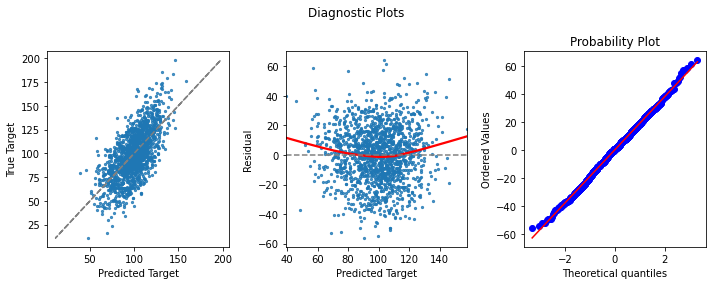

In [31]:
diagnostic_plots(fit.fittedvalues, y_train, fit.resid)
plt.savefig("baseline_diagnostic_plot.png", dpi=400, facecolor ="w", bbox_inches="tight")

## EDA

In [75]:
df_eda = df_train[['Age', 'Debut','OPS+_3y_0','PA_3y_0','PA_cum_0','p/pa','HardH%','launch_angle_avg',
                   'LD%','GB/FB','Pull%','Oppo%','z_swing_percent', 'iz_contact_percent', 
                   'oz_swing_percent','sprint_speed','OPS+']]

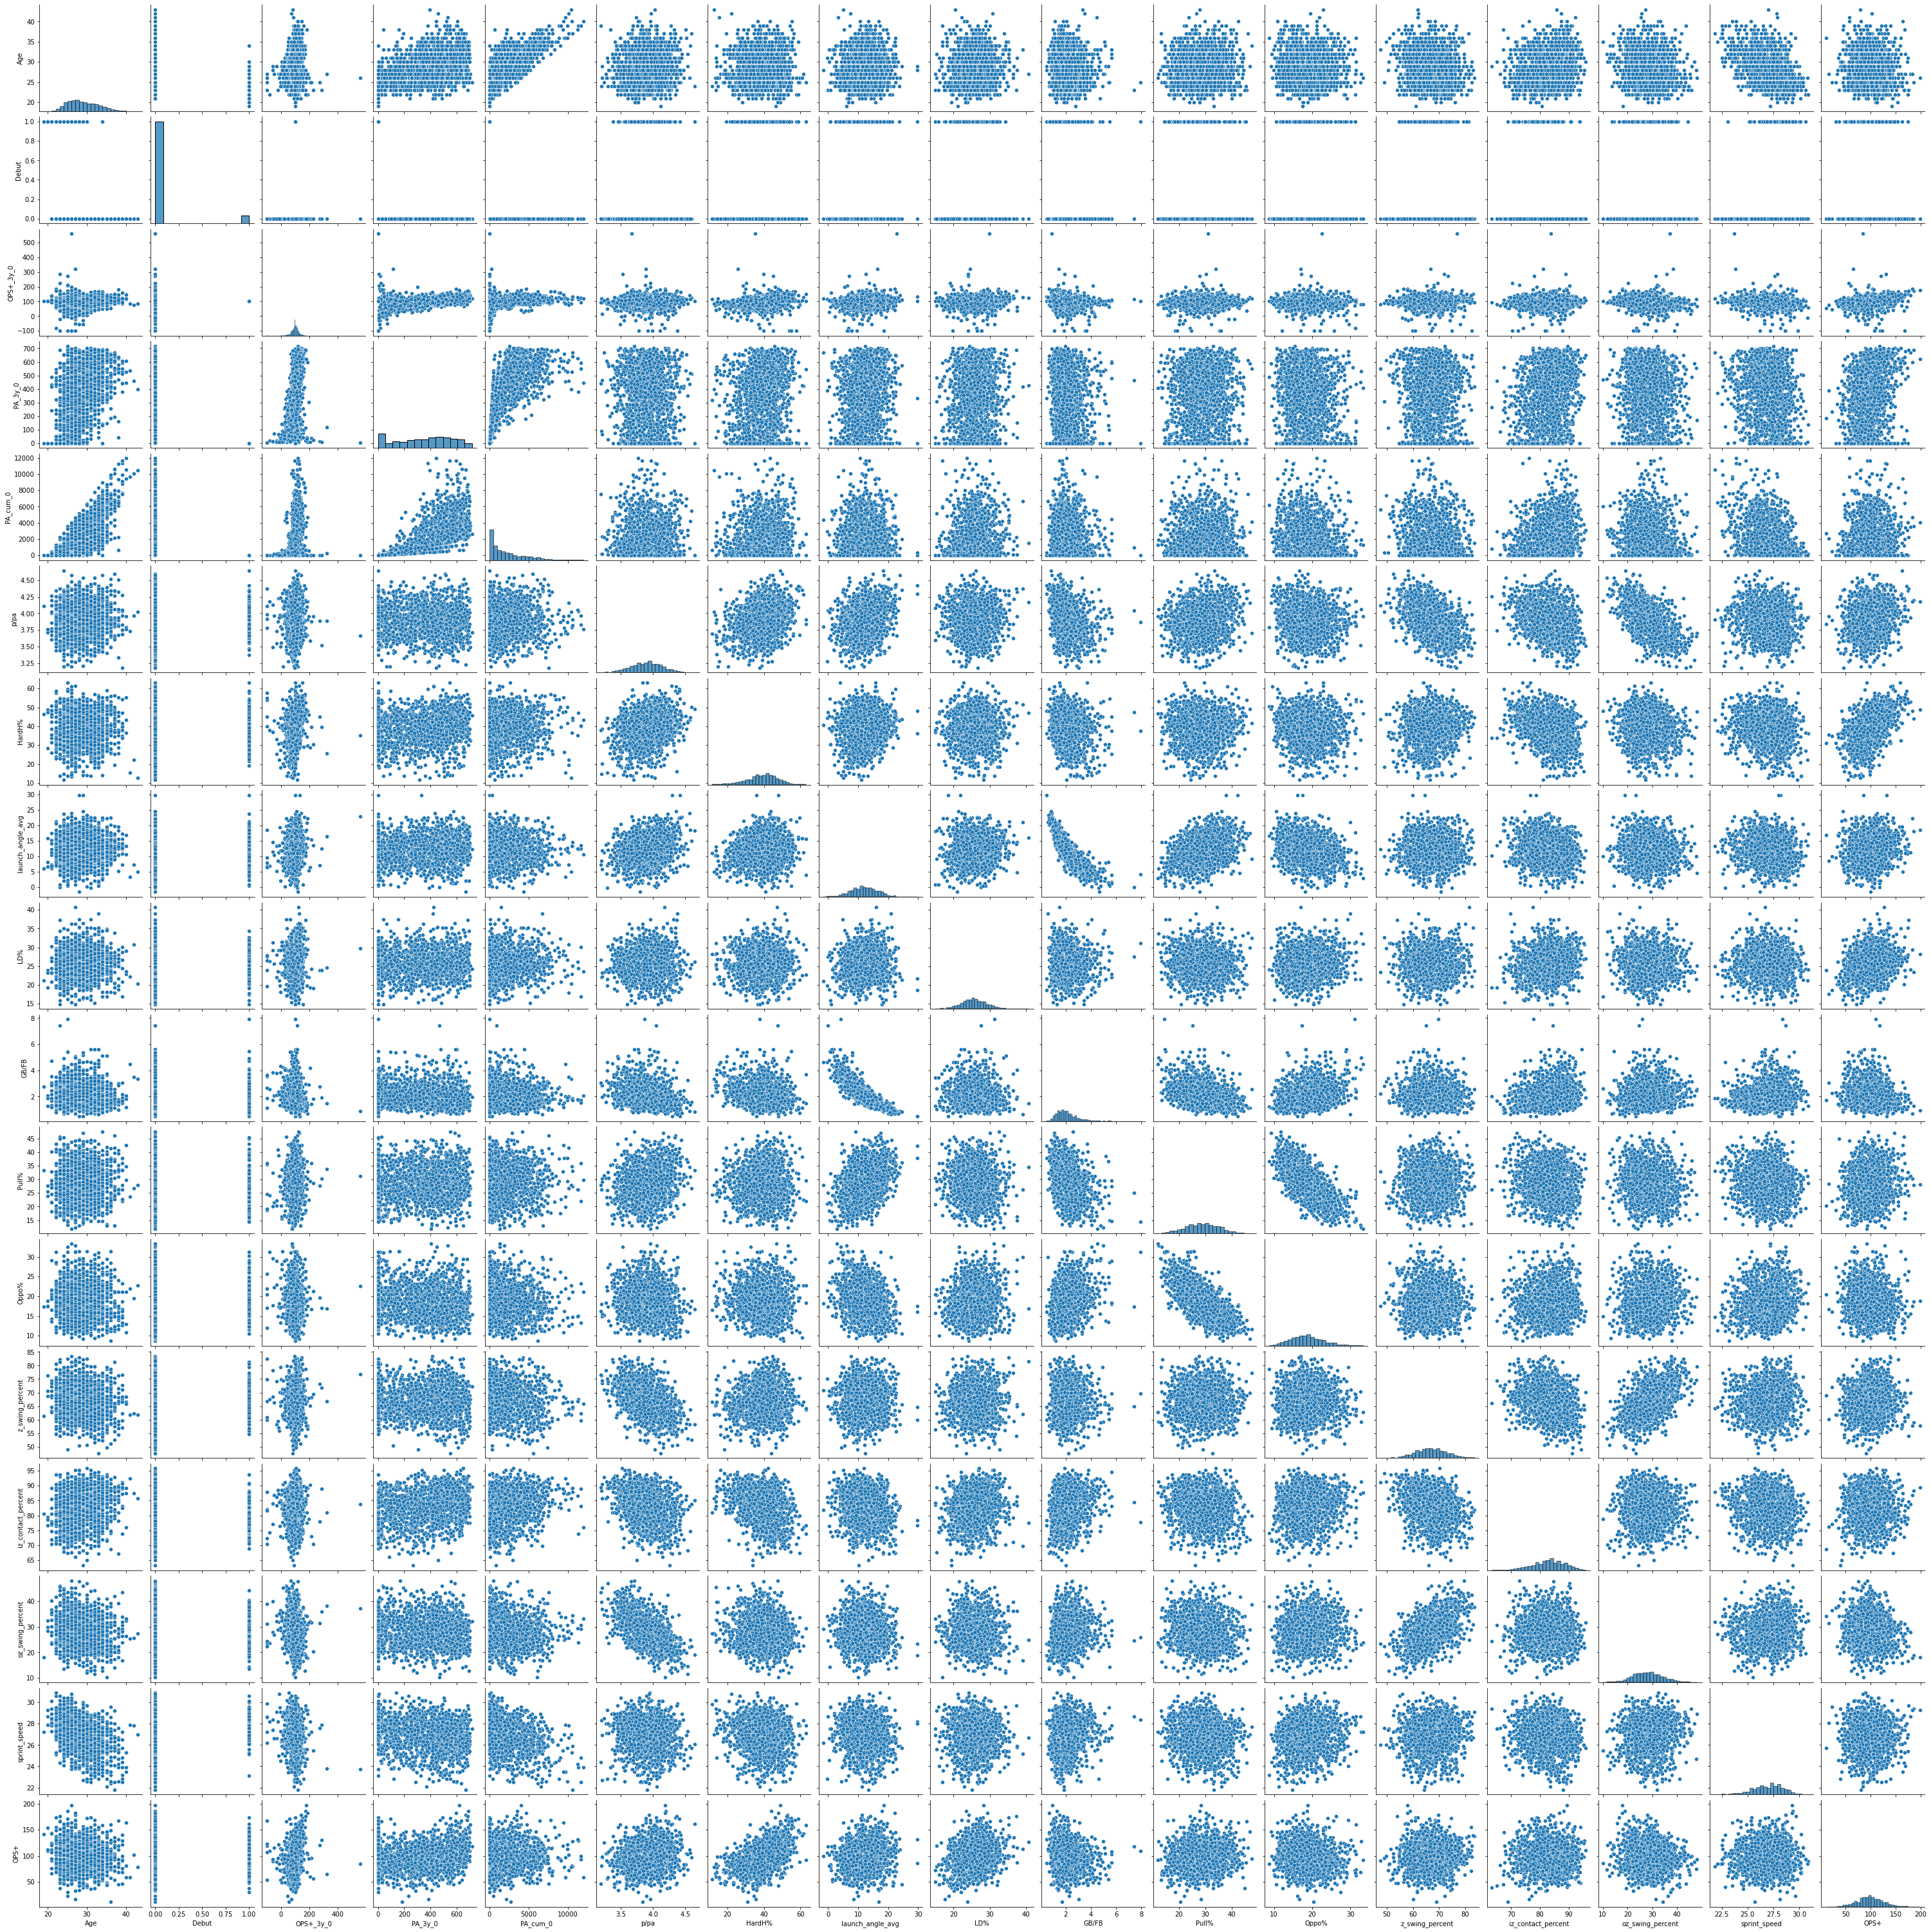

In [76]:
sns.pairplot(df_eda)
plt.savefig("basic_pairplot.png", facecolor ="w", bbox_inches="tight");

In [77]:
df_eda.corr()

Age     Debut  OPS+_3y_0   PA_3y_0  PA_cum_0  \
Age                 1.000000 -0.333205   0.120504  0.493263  0.795134   
Debut              -0.333205  1.000000   0.017067 -0.475836 -0.274030   
OPS+_3y_0           0.120504  0.017067   1.000000  0.360407  0.257473   
PA_3y_0             0.493263 -0.475836   0.360407  1.000000  0.703297   
PA_cum_0            0.795134 -0.274030   0.257473  0.703297  1.000000   
p/pa                0.063012  0.042229   0.042818 -0.021509 -0.007235   
HardH%             -0.024886  0.035995   0.216387  0.121679  0.066816   
launch_angle_avg    0.032661 -0.023252   0.147302  0.082843  0.032396   
LD%                 0.035697 -0.032779   0.046053  0.058390  0.048245   
GB/FB              -0.029032  0.028033  -0.162186 -0.102232 -0.059252   
Pull%               0.032751 -0.040698   0.074072  0.067888  0.051565   
Oppo%              -0.051843  0.044190  -0.104848 -0.119521 -0.107118   
z_swing_percent    -0.140633  0.005406   0.032326 -0.017429 -0.065977   
iz_contact_percent  0.174979 -0.115111   0.033910  0.229043  0.213143   
oz_swing_percent   -0.150838 -0.004157  -0.076048 -0.044318 -0.073256   
sprint_speed       -0.467125  0.181664  -0.159035 -0.222077 -0.382984   
OPS+               -0.075615  0.036519   0.259305  0.203636  0.075892   

                        p/pa    HardH%  launch_angle_avg       LD%     GB/FB  \
Age                 0.063012 -0.024886          0.032661  0.035697 -0.029032   
Debut               0.042229  0.035995         -0.023252 -0.032779  0.028033   
OPS+_3y_0           0.042818  0.216387          0.147302  0.046053 -0.162186   
PA_3y_0            -0.021509  0.121679          0.082843  0.058390 -0.102232   
PA_cum_0           -0.007235  0.066816          0.032396  0.048245 -0.059252   
p/pa                1.000000  0.265600          0.275251  0.007451 -0.292208   
HardH%              0.265600  1.000000          0.086620  0.024582 -0.192125   
launch_angle_avg    0.275251  0.086620          1.000000  0.057424 -0.861199   
LD%                 0.007451  0.024582          0.057424  1.000000 -0.021190   
GB/FB              -0.292208 -0.192125         -0.861199 -0.021190  1.000000   
Pull%               0.184240  0.010661          0.389219 -0.071000 -0.355152   
Oppo%              -0.111220 -0.104861         -0.282851  0.127006  0.297905   
z_swing_percent    -0.470115  0.072492          0.070184  0.012970 -0.066018   
iz_contact_percent -0.332583 -0.348031         -0.177771  0.154171  0.226565   
oz_swing_percent   -0.619262 -0.096533         -0.086160 -0.030325  0.117367   
sprint_speed       -0.081608 -0.151156         -0.136743 -0.040232  0.150207   
OPS+                0.162038  0.508982          0.158873  0.265443 -0.218867   

                       Pull%     Oppo%  z_swing_percent  iz_contact_percent  \
Age                 0.032751 -0.051843        -0.140633            0.174979   
Debut              -0.040698  0.044190         0.005406           -0.115111   
OPS+_3y_0           0.074072 -0.104848         0.032326            0.033910   
PA_3y_0             0.067888 -0.119521        -0.017429            0.229043   
PA_cum_0            0.051565 -0.107118        -0.065977            0.213143   
p/pa                0.184240 -0.111220        -0.470115           -0.332583   
HardH%              0.010661 -0.104861         0.072492           -0.348031   
launch_angle_avg    0.389219 -0.282851         0.070184           -0.177771   
LD%                -0.071000  0.127006         0.012970            0.154171   
GB/FB              -0.355152  0.297905        -0.066018            0.226565   
Pull%               1.000000 -0.731056         0.000552           -0.091519   
Oppo%              -0.731056  1.000000        -0.007193            0.068735   
z_swing_percent     0.000552 -0.007193         1.000000           -0.298696   
iz_contact_percent -0.091519  0.068735        -0.298696            1.000000   
oz_swing_percent   -0.129850  0.086400         0.544416           -0.007486   
sprin

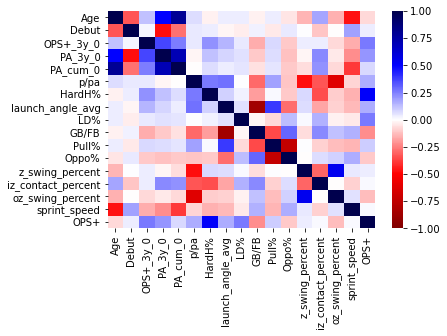

In [81]:
upper = np.triu(df_eda.corr())
sns.heatmap(df_eda.corr(), cmap="seismic_r", annot=False, vmin=-1, vmax=1);

## Feature Engineering

### launch_angle_avg

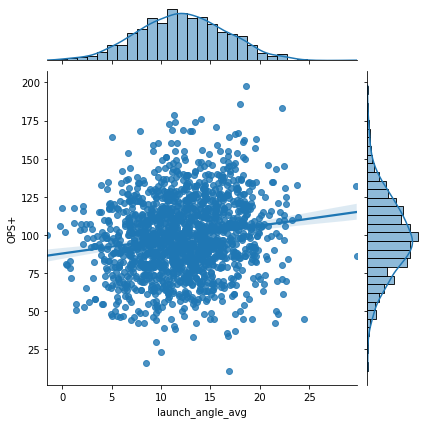

In [83]:
sns.jointplot(x=df_train['launch_angle_avg'], y=df_train['OPS+'], kind='reg')

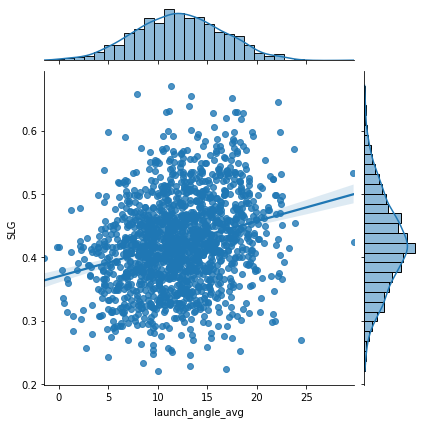

In [107]:
sns.jointplot(x=df_train['launch_angle_avg'], y=df_train['SLG'], kind='reg')

In [85]:
df_train['launch_angle_avg'].describe()

count    1540.000000
mean       12.178247
std         4.405548
min        -1.500000
25%         9.200000
50%        12.200000
75%        15.200000
max        29.800000
Name: launch_angle_avg, dtype: float64

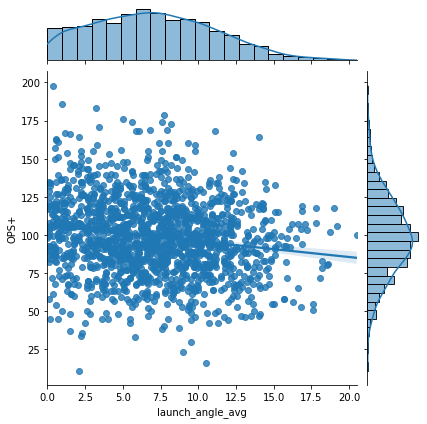

In [158]:
sns.jointplot(x=df_train['launch_angle_avg'].map(lambda x : abs(x-19)), y=df_train['OPS+'], kind='reg')

In [186]:
df_train['launch_angle_avg'].map(lambda x : abs(x-19)).describe()

count    1540.000000
mean        7.040974
std         4.045723
min         0.000000
25%         3.900000
50%         6.800000
75%         9.800000
max        20.500000
Name: launch_angle_avg, dtype: float64

In [157]:
for la in np.arange(0, 29, 0.5):
    print(str(la)+ ": " )
    print(pd.DataFrame([df_train['launch_angle_avg'].map(lambda x : abs(x-la)),df_train['OPS+']]).T.corr())
    

0.0: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159128
OPS+                      0.159128  1.000000
0.5: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159489
OPS+                      0.159489  1.000000
1.0: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159735
OPS+                      0.159735  1.000000
1.5: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159889
OPS+                      0.159889  1.000000
2.0: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159809
OPS+                      0.159809  1.000000
2.5: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159977
OPS+                      0.159977  1.000000
3.0: 
                  launch_angle_avg      OPS+
launch_angle_avg          1.000000  0.159985
OPS+                      0.159985  1.000000
3.5: 
       

In [182]:
df_train['Age'].describe()

count    1540.000000
mean       28.441558
std         3.927357
min        19.000000
25%        25.000000
50%        28.000000
75%        31.000000
max        43.000000
Name: Age, dtype: float64

In [161]:
for age in np.arange(0, 44):
    print(str(age)+ ": " )
    print(pd.DataFrame([df_train['Age'].map(lambda x : abs(x-age)),df_train['OPS+']]).T.corr())

0: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
1: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
2: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
3: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
4: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
5: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
6: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
7: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
8: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
9: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
10: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
11: 
           Age      OPS+
Age   1.000000 -0.075615
OPS+ -0.075615  1.000000
12: 
           Age      OPS+
Age   1.000000 -0.07

In [179]:
pd.DataFrame([df_train['Age'] - df_train['MLB_year'],df_train['OPS+']]).T.corr()

Unnamed 0      OPS+
Unnamed 0   1.000000 -0.131552
OPS+       -0.131552  1.000000

In [183]:
pd.DataFrame([df_train['z_swing_percent'] * df_train['iz_contact_percent'],df_train['OPS+']]).T.corr()

Unnamed 0      OPS+
Unnamed 0   1.000000  0.039461
OPS+        0.039461  1.000000

In [180]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Age', -1.1652622567480791e-08),
 ('Debut', 3.701119890082847e-10),
 ('OPS+_3y_0', 3.4422266900786596e-07),
 ('PA_3y_0', 1.6364000044630364e-06),
 ('PA_cum_0', 6.501905169811993e-06),
 ('p/pa', 1.5058141698937449e-09),
 ('HardH%', 1.6543871844414952e-07),
 ('launch_angle_avg', 2.7295281824841452e-08),
 ('LD%', 3.72691776692361e-08),
 ('GB/FB', -7.187612588640868e-09),
 ('Pull%', 2.429764210324379e-08),
 ('Oppo%', -1.797188523269955e-08),
 ('z_swing_percent', 7.83367477911716e-09),
 ('iz_contact_percent', 2.01947022764044e-09),
 ('oz_swing_percent', -3.0249997944782546e-08),
 ('sprint_speed', 5.237250455147653e-10)]

In [181]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_lasso.coef_))

[('Age', -0.0),
 ('Debut', 0.0),
 ('OPS+_3y_0', 0.0),
 ('PA_3y_0', 0.0),
 ('PA_cum_0', 0.0),
 ('p/pa', 0.0),
 ('HardH%', 0.0),
 ('launch_angle_avg', 0.0),
 ('LD%', 0.0),
 ('GB/FB', -0.0),
 ('Pull%', 0.0),
 ('Oppo%', -0.0),
 ('z_swing_percent', 0.0),
 ('iz_contact_percent', 0.0),
 ('oz_swing_percent', -0.0),
 ('sprint_speed', 0.0)]